# Import preprocessed data

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
import string
import requests
from bs4 import BeautifulSoup
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
import matplotlib.colors as mcolors

warnings.filterwarnings("ignore")
plt.style.use('dark_background')
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# download stopwords for 'associated words' analysis
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:

# get the movie datafram
Horror_movies = pd.read_csv('data/Horror_Movies_Clean.csv')
Horror_movies = Horror_movies.rename(columns={'Weekipedia_ID': 'Wikipedia movie ID'})

# load and process the actor dataset

character_path = os.path.join(os.getcwd(), 'data/MovieSummaries', 'character.metadata.tsv')
character_columns = [
   'Wikipedia movie ID', 'Freebase Movie ID', 'Movie release date','Character Name', 'Actor DOB', 'Actor gender', 'Actor height', 'Actor ethnicity', 
    'Actor Name', 'Actor age at movie release', 'Freebase character map1', 'Freebase character map2', 'Freebase character map3'
]
character_metadata= pd.read_csv(character_path, sep='\t', names = character_columns)

# dict that maps each freebase id with the ethnicity (from freebase website)
ethnicity_dict={
    "/m/01kb9y": "Multiracial",
    "/m/05qb937": "Venezuelans",
    "/m/09v5bdn": "Puerto Ricans",
    "/m/02pfy17": "Syrian people",
    "/m/013xrm": "Germans",
    "/m/01n94b": "Slovaks",
    "/m/02w7gg": "English people",
    "/m/0x67": "African American",
    "/m/011bn6ys": None,
    "/m/0118b8ry": None,
    "/m/03bkbh": "Irish people",
    "/m/0318mh": "Finns",
    "/m/027hhf": "Arbëreshë people",
    "/m/04c28": "Kurds",
    "/m/0cx3p": "Berbers",
    "/m/032j30": "Native Hawaiians",
    "/m/0gcp7x": "Iranian Azerbaijanis",
    "/m/013xrm": "Germans",
    "/m/038723": "Greek American",
    "/m/0d2by": "Chinese American",
    "/m/09vc4s": "English American",
    "/m/0912ll": "Dominican American",
    "/m/07mqps": "Dutch-American",
    "/m/01qhm_": "German American",
    "/m/0dbxy": "Cherokee",
    "/m/013s41": "Bulgarians",
    "/m/01km_m": "Slovenes",
    "/m/02ctzb": "White people",
    "/m/033tf_": "Irish American",
    "/m/0222qb": "Italian people",
    "/m/0jt85pd": "Greeks",
    "/m/03w9xlf": "Filipino Italian",
    "/m/0j251_s": "Arabs in France",
    "/m/0bwhd5z": "Harari people",
    "/m/0k0t_dz": "Caucasian race",
    "/m/09743": "Pashtun",
    "/m/03lmx1": "Scottish people",
    "/m/0bpjh3": "Bengalis",
    "/m/0j63_pr": "French Canadian American",
    "/m/0jt8h6f": "Latin Americans",
    "/m/02gx2x": "Javanese people",
    "/m/048z7l": "Jewish American",
    "/m/03ts0c": "French people",
    "/m/013s3n": "Czechs",
    "/m/0268_k": "Danes",
    "/m/059_w": "Native Americans in the United States",
    "/m/09kr66": "Russian American",
    "/m/0f3v0": "Comanche",
    "/m/09743": "Pashtun",
    "/m/09vc4s": "English American",
    "/m/0bpjh3": "Bengalis",
    "/m/0x67": "African American",
    "/m/0j3c70b": "Jamaicans",
    "/m/0dryh9k": "Indian people",
    "/m/09vc4s": "English American",
    "/m/0dbxy": "Cherokee",
    "/m/03bkbh": "Irish people",
    "/m/02pfy17": "Syrian people",
    "/m/0cx3p": "Berbers",
    "/m/03bkbh": "Irish people",
    "/m/02ctzb": "White people",
    "/m/02w7gg": "English people",
    "/m/033tf_": "Irish American",
    "/m/09vc4s": "English American",
    "/m/0bwhd5z": "Harari people",
    "/m/0k0t_dz": "Caucasian race",
    "/m/013xrm": "Germans",
    "/m/09743": "Pashtun",
    "/m/03w9xlf": "Filipino Italian",
    "/m/0j251_s": "Arabs in France",
    "/m/04c28": "Kurds",
    "/m/0j63_pr": "French Canadian American",
    "/m/038723": "Greek American",
    "/m/0134vqyy": "Scottish American",
    "/m/0dbxy": "Cherokee",
    "/m/05qb937": "Venezuelans",
    "/m/033tf_": "Irish American",
    "/m/03bkbh": "Irish people",
    "/m/04c28": "Kurds",
    "/m/0j251_s": "Arabs in France",
    "/m/0bpjh3": "Bengalis",
    "/m/0dbxy": "Cherokee",
    "/m/038723": "Greek American"
}

character_metadata['ethnicity_clean'] = character_metadata['Actor ethnicity'].map(ethnicity_dict)
character_metadata['Release_year'] = character_metadata['Movie release date'].astype(str).str.extract(r'(\d{4})')
character_metadata['Release_year'] = pd.to_numeric(character_metadata['Release_year'])
character_metadata = character_metadata.drop(['Movie release date', 'Actor ethnicity'], axis=1)
# replace all negative ages by nan
character_metadata['Actor age at movie release'] = character_metadata['Actor age at movie release'].where(character_metadata['Actor age at movie release'] >= 0, np.nan)

Horror_movies_with_actors = pd.merge(Horror_movies, character_metadata, on=['Wikipedia movie ID', 'Release_year'], how='left')
# for each movie, only keep the first actor
Horror_movies_with_first_actor = Horror_movies_with_actors.drop_duplicates(subset=['Name', 'Release_year'], keep='first')

# function to remove abnormal characters in titles from the additional dataset
def clean_movie_title(title):
    if title.startswith('#'):
        title = title[1:]
    title = title.replace('_', ' ')
    return title
# apply the function to the Name column of the df
Horror_movies_with_actors['Name'] = Horror_movies_with_actors['Name'].apply(clean_movie_title)


# 1. Analyse work occurences in titles throughout the decades

In [3]:
# UTILS FOR THIS WORD OCCURENCE PART

def preprocess_title(title):

    """preprocess the titles and tokenize them"""

    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(title.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]


def get_word_proportions(df, year_start, year_end, words_to_analyze):

    """compute the proportion of movies with given words in their titles 
    in a specified time period"""

    # filter the df to keep only the movies released within the specified time period
    filtered_df = df[(df['Release_year'] >= year_start) & (df['Release_year'] <= year_end)]
    # count the total number of movies released during the period for proportion calculation
    total_movies = len(filtered_df)
    # count the movies with given words in their titles
    word_counts = Counter()
    for title in filtered_df['processed_title']:
        word_counts.update([word for word in title if word in words_to_analyze])
    # return the proportion of movies for each word
    return {word: (word_counts[word] / total_movies) if total_movies > 0 else 0 for word in words_to_analyze}


def analyze_word_proportions_with_highlights(df, words_to_analyze, time_intervals, 
                                             custom_palette="inferno", chart_title="Word Proportions by Decade", 
                                             show_lines=False):

    """make a plot of the evolution of proportion of movies with given words in their titles througout the decades"""
    
    df = df.copy()  # copy the df to avoid modifying the original

    # apply title preprocessing function 
    df['processed_title'] = df['Name'].apply(preprocess_title)
    
    # apply the function that computes the porportions for the given words
    # for all the specified time periods
    proportions_by_decade = {}
    for start, end in time_intervals:
        proportions_by_decade[f"{start}\n{end}"] = get_word_proportions(df, start, end, words_to_analyze)
    
    # prepare data for visualization
    visualization_data = []
    for decade, proportions in proportions_by_decade.items():
        for word, proportion in proportions.items():
            visualization_data.append({'decade': decade, 'word': word, 'proportion': proportion})
    
    viz_df = pd.DataFrame(visualization_data)
    
    # identify the decades in which there is a peak for each word
    max_decades = {}
    for word in words_to_analyze:
        word_df = viz_df[viz_df['word'] == word]
        # check which decade has the max proportion for the given word
        max_decade = word_df.loc[word_df['proportion'].idxmax()]
        max_decades[word] = (max_decade['decade'], max_decade['proportion'])
    
    # create the color palette
    palette = sns.color_palette(custom_palette, n_colors=len(words_to_analyze))
    color_map = {word: palette[i] for i, word in enumerate(words_to_analyze)}
    
    # visualization with barplots
    plt.figure(figsize=(8, 8))
    ax = sns.barplot(data=viz_df, x='decade', y='proportion', hue='word', dodge=True, palette=palette, alpha=0.6)
    
    # iterate through all the given words
    # add anotation to show in which decade each word peaks
    for word, (decade, _) in max_decades.items():
        # get coordinates of the peak
        row = viz_df[(viz_df['word'] == word) & (viz_df['decade'] == decade)]
        x = row.index[0]  
        y = row['proportion'].values[0]
        
        # find the location of the bar to put the text
        bar_group_idx = list(viz_df['decade'].unique()).index(decade)
        bar_width = ax.patches[bar_group_idx].get_width() / len(words_to_analyze)
        
        # compute the specific position for the word
        x_coord = bar_group_idx + bar_width * (words_to_analyze.index(word) - len(words_to_analyze) / 2 + 0.5)
        
        # add the text at the found position
        plt.text(
            x=x_coord, y=y, s=word,
            ha='center', va='bottom', color='white', fontsize=12, fontweight='bold', rotation=0
        )
    
    # if the show_lines argument is True, we add lines for each word to show the evolution of porportions
    # troughout the decades
    if show_lines:
        for word in words_to_analyze:
            word_df = viz_df[viz_df['word'] == word]
            plt.plot(
                range(len(word_df['decade'])), word_df['proportion'],
                label=f"Trend: {word}", color=color_map[word], lw=3
            )
    
    plt.title(chart_title, color='white')
    plt.xlabel("Decade", color='white')
    plt.ylabel("Proportion of Movie Titles with Corresponding Word", color='white')
    plt.legend(title="Words", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, labelcolor='white')
    plt.tight_layout()
    plt.show()


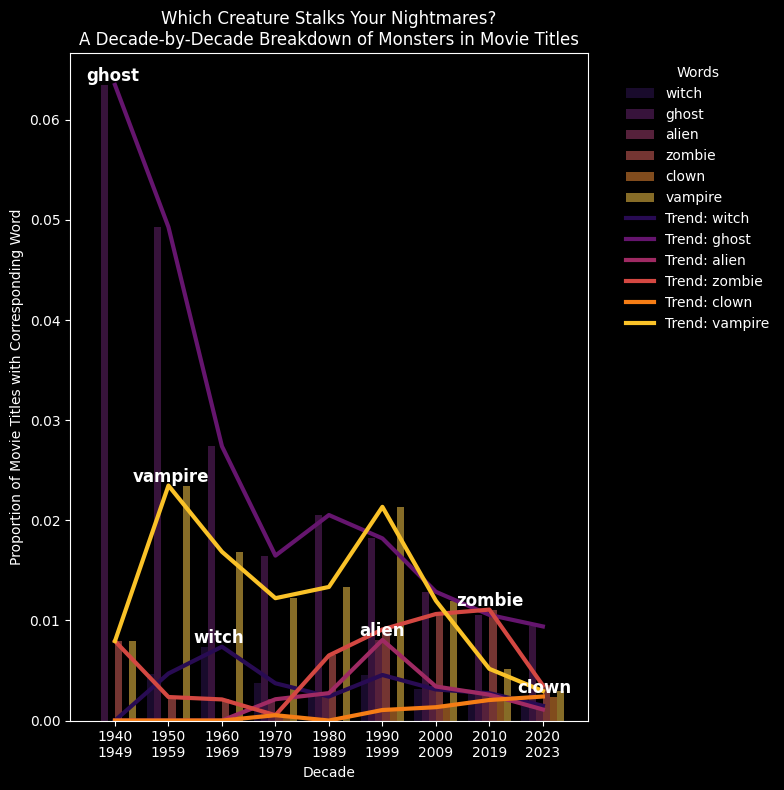

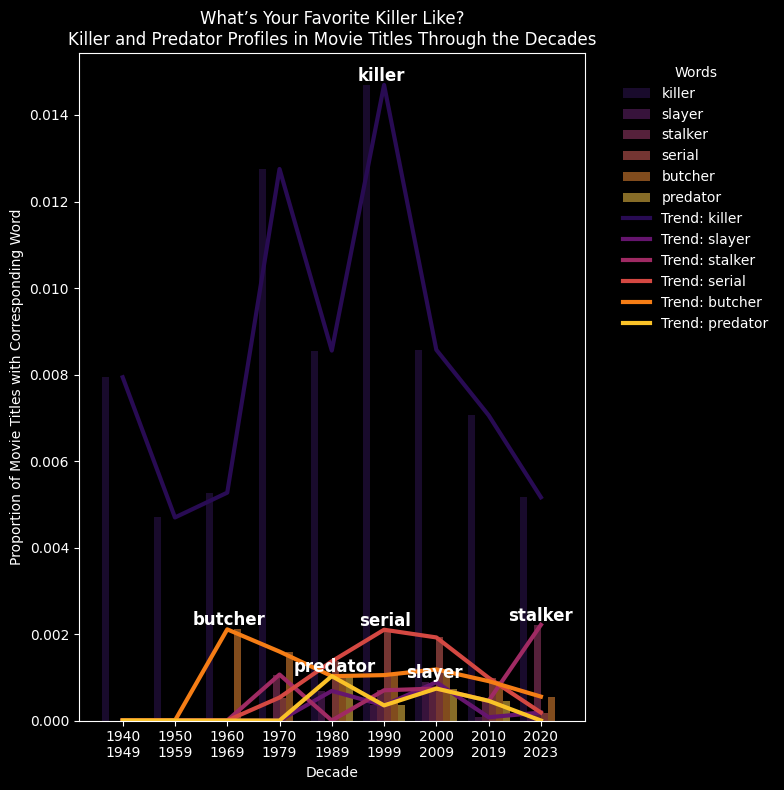

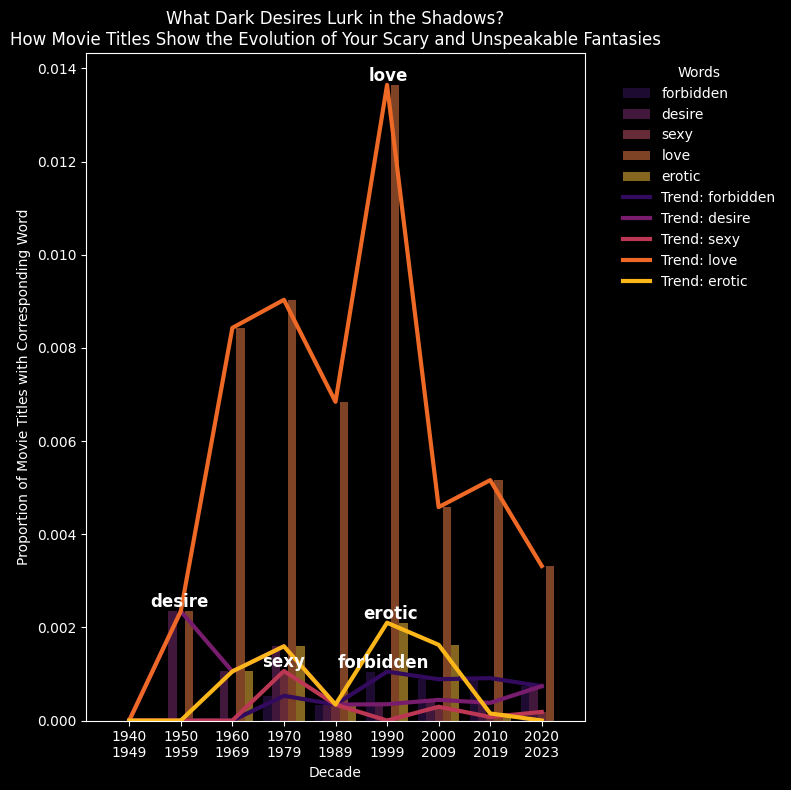

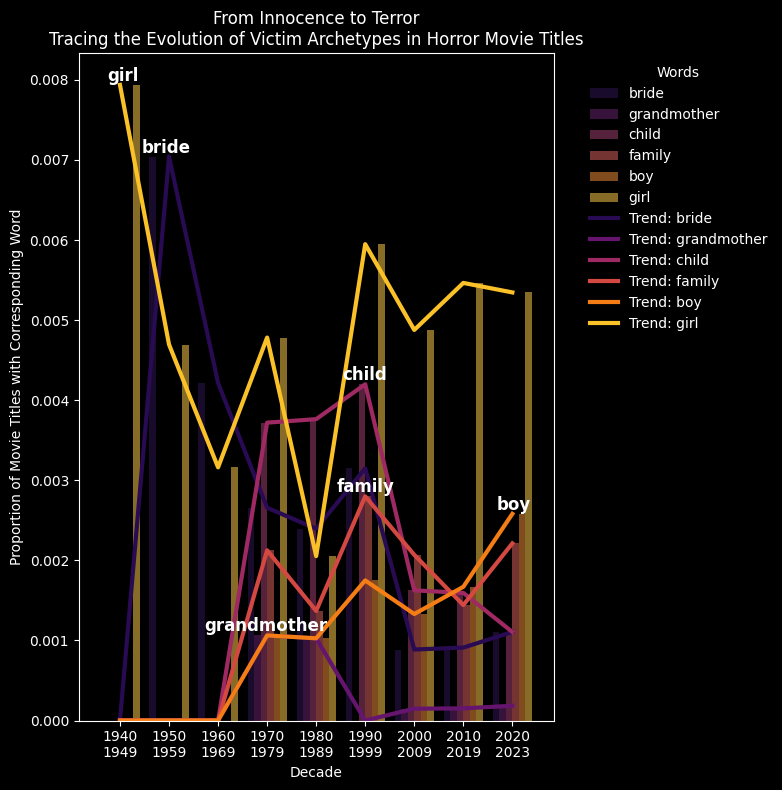

In [4]:
# specify the time intervals in which we want to analyse the proportion of word occurences in movie tutles
time_intervals = [(1940, 1949), (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2009), (2010, 2019), (2020, 2023)]

# which creatures scare people?
analyze_word_proportions_with_highlights(Horror_movies, ['witch', 'ghost', 'alien', 'zombie', 'clown', 'vampire'], time_intervals, custom_palette='inferno', show_lines=True, chart_title="Which Creature Stalks Your Nightmares?\nA Decade-by-Decade Breakdown of Monsters in Movie Titles")
# words describing the different types of killers
analyze_word_proportions_with_highlights(Horror_movies, ['killer','slayer', 'stalker', 'serial', 'butcher', 'predator'], time_intervals, custom_palette="inferno", show_lines=True, chart_title='What’s Your Favorite Killer Like?\nKiller and Predator Profiles in Movie Titles Through the Decades')
# dark and forbidden fantasies 
analyze_word_proportions_with_highlights(Horror_movies, ['forbidden', 'desire', 'sexy', 'love', 'erotic'], time_intervals, custom_palette="inferno", show_lines=True, chart_title='What Dark Desires Lurk in the Shadows?\nHow Movie Titles Show the Evolution of Your Scary and Unspeakable Fantasies')
# words for the victims/preys
analyze_word_proportions_with_highlights(Horror_movies, ['bride', 'grandmother', 'child', 'family', 'boy', 'girl'], time_intervals, custom_palette="inferno", show_lines=True, chart_title='From Innocence to Terror\nTracing the Evolution of Victim Archetypes in Horror Movie Titles')

# 2. Analyse which words are associated with given keywords in movie titles

In [5]:
# UTILS FOR THE ASSOCIATED WORDS PART

def analyse_association_mots(df, keyword, distance=2, Stopwords=None):
    """make an image showing the words associated with keyword in movie titles
    distance allows to decide if we only want the words directly next to the keyword in the title
    or more"""
    
    # be sure that there is not 2 times the same movie in the df 
    # we consider that if 2 movies have the same title and release year, its a duplicate of the same movie
    df = df.drop_duplicates(subset=['Name', 'Release_year'])
    
    # define the stopwords if not given as arguments
    # stopwords are words that we will ignore because they carry little semantic meaning
    # and do not contribute significantly to the overall understanding of text
    if Stopwords is None:
        Stopwords = set(stopwords.words('english'))
    # define ponctuation to be removed from the titles
    punctuation = string.punctuation
    
    # filter only the movies with the keyword in their title
    filtered_df = df[df['Name'].str.contains(rf'\b{keyword}\b', case=False, na=False)]
    
    # list to store associated keywords
    associated_words = []
    
    # extract the neighbouring words in each title:
    for title in filtered_df['Name']:
        # start by removing ponctuation because we do not want to see it on the image
        title = title.translate(str.maketrans('', '', punctuation))
        
        # split the title into separate words
        words = title.lower().split()  
        for i, word in enumerate(words):
            if word == keyword:
                # find window of words around keyword depending on the distance given as argument
                start = max(i - distance, 0)
                end = min(i + distance + 1, len(words))
                # add the associated words to the list if they are not stopwords
                for w in words[start:i] + words[i+1:end]:
                    if w not in Stopwords:
                        associated_words.append(w)
    
    # for each associated word count the number of times it has occured
    word_count = pd.Series(associated_words).value_counts().to_dict()

    # visualize the results
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',  
        colormap='inferno'
    ).generate_from_frequencies(word_count)

    # plot the results
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Recurrent Words Associated With {keyword.upper()} in Movie Titles')
    plt.show()

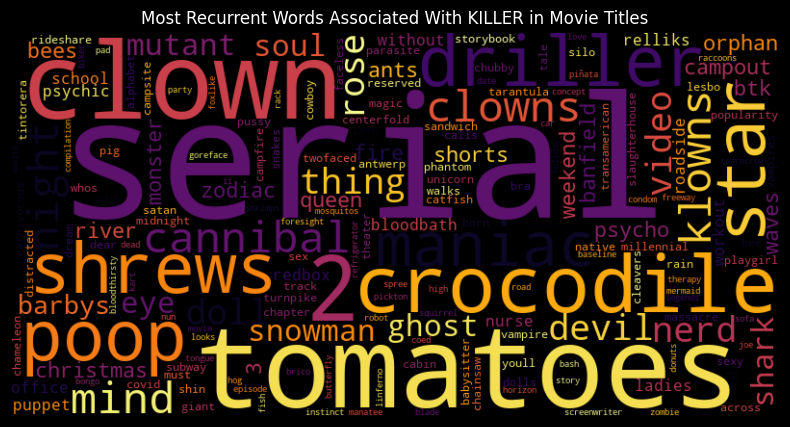

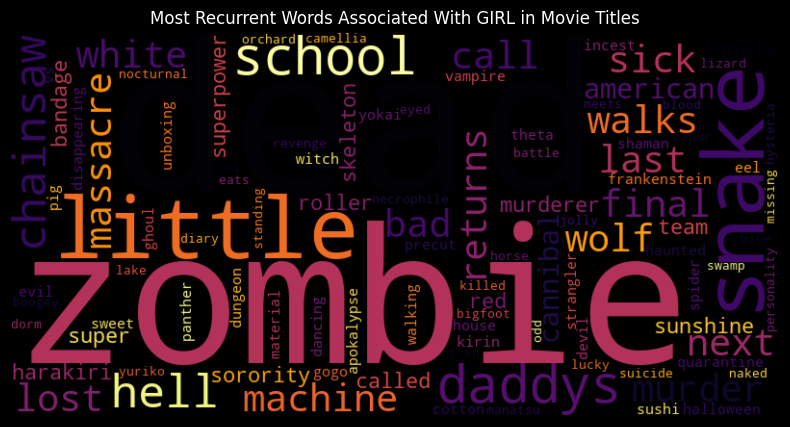

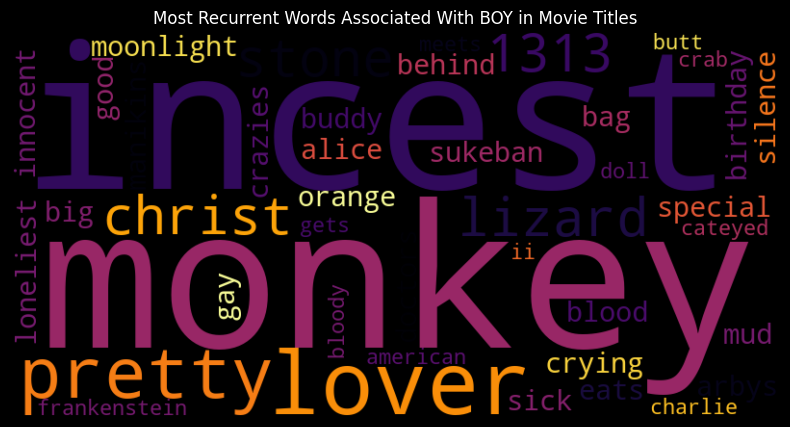

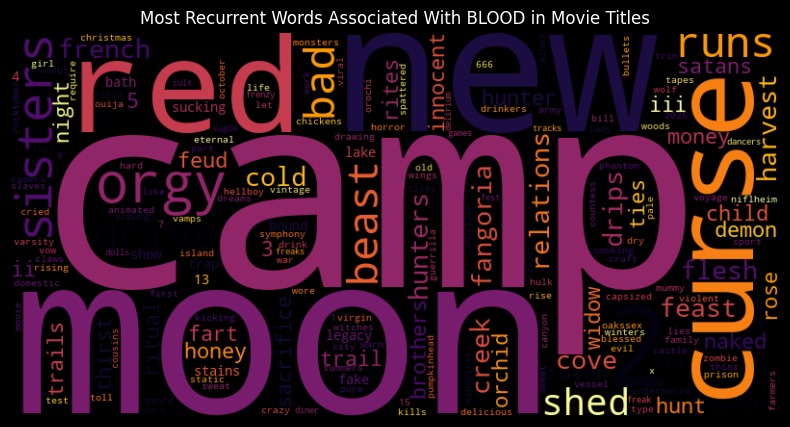

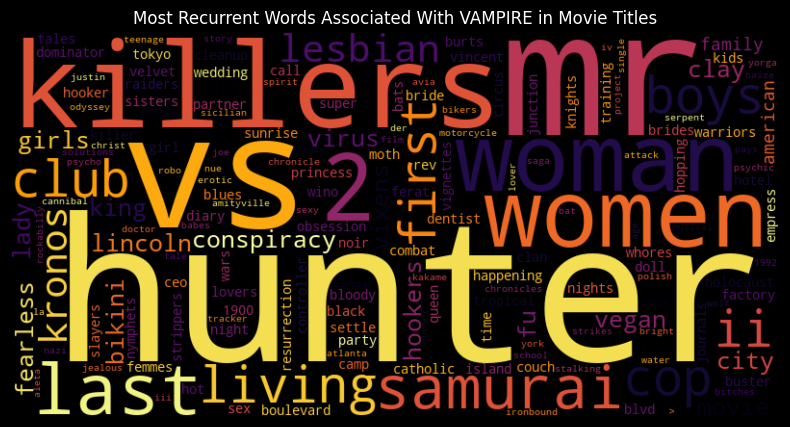

In [6]:
# look at the words associated with severaé keywords
# we chose distance=1 to have only the words just before or just after the chose keyword
analyse_association_mots(Horror_movies, 'killer', distance=1)
analyse_association_mots(Horror_movies, 'girl', distance=1)
analyse_association_mots(Horror_movies, 'boy', distance=1)
analyse_association_mots(Horror_movies, 'blood', distance=1)
analyse_association_mots(Horror_movies, 'vampire', distance=1)

# Analyse actor profiles based on keyword present in movie title

In [7]:
# in our actor dataframe, many actors were missing, along with their gender and ethnicities
# we do web scraping on IMDb and wikipedia to try to retrieve as much information as possible
# as the ethncity is not directly given on wikipedia, we retrieve the nationalities of actors
# finally, we gave all nationalities present in the df to chatGPT and asked to classify the results
# into the ethnicity dictionnary shown below
# this dictionnary will then be used to regroup the very broad range of nationalities into smaller 
# ethnicity groups for better visualisation of the results

ethnicity_map = {
    "North American": [
        "Américaine", "américaine", "Américain", "African American", "German American", 
        "English American", "AméricaineCanadienne", "AméricaineItalienne(depuis 2005)[1]", 
        "AméricaineBritannique", "AméricaineAlbanaise", "Sud-africaineAméricaine", 
        "AméricaineNéerlandaise", "CubaineVénézuélienneAméricaine(depuis 2007)", 
        "MexicaineAméricaineLibanaise", "Canadienne(d'origine)Américaine(à partir de1935)", 
        "Canadienne", "États-Unis", "britanniqueAméricaine", "Irish American",
        "canadienne", "soviétiqueaméricaine", "Dutch-American", "américainefrançaise", 
        "CanadienAméricain", "Jewish American",
        "North American",
        "AméricaineRoumaineBritannique",
        "Canada",
        "AméricaineCoréenne",
        "AméricaineMexicaine",
        "CanadienneIrlandaise",
        "North American",            
        "AméricaineSud-Africaine",
        "Greek American",
        "CanadienneAméricaine",
        "AméricaineBahaméenne",
        "Americaine"
    ],
    "European": [
        "britannique", "Britannique", "BulgareCanadienne", "English people", "Française", 
        "française", "Allemande", "allemande", "BritanniqueAméricaine", "Irish people", 
        "White people", "Canadien", "Suédoise", "britanniqueaméricaine", "Australien", 
        "Écosse", "Belge", "Italienne", "TchécoslovaquepuisTchèque", "thaïlandaise", 
        "tchèque", "Néo-zélandaiseHongroise", "BritanniqueSuisse(depuis 2022)", 
        "Néo-ZélandaiseAméricaine", "PolonaisAméricain", "irlandaise", "FrançaiseAméricaine", 
        "Néerlandaise", "Italian people", "danoise", "Germans", "Royaume-Uni", 
        "italienne", "French people", "Espagnol", "espagnole", "Espagnole", 
        "HongroiseAméricainenaturalisée", "Suisse", "FrançaiseIrlandaise", "Danes", 
        "tchécoslovaque", "Espagne", "Italien", "Français", "Irlandais", "Finlandaise", 
        "allemandetchécoslovaque", "Norvégienne", "italien", "allemandeaméricaine",
        "European",
        "grecque",
        "Danoise",
        "Autrichienne",
        "Hongrois",
        "Allemande(d'origine)Américaine(naturalisée)",
        "italienneaméricaine",
        "Suède",
        "Soviétique→Russe",
        "BritanniquePakistanaise",
        "BritanniqueSierra-léonaise[1]",
        "Suédois",
        "European",     
        "AllemandeIrlandaise",
        "IrlandaiseAméricaine(depuis le 23 septembre 2004)",
        "FrançaiseItalienne",
        "ItalienneSuédoise",
        "néerlandaise",
        "Allemand",
        "Allemagne",
        "polonaise",
        "islandaiseaméricaine",
        "suédoiseaméricaine",
        "YougoslaveItalienne",
        "Néerlandais",
        "norvégienne",
        "Irlandaise",
        "Scottish people",
        "AutrichienneAméricaine(depuis 1983)"

    ], 
    "African": [
        "African American", "Sud-africaineAméricaine", "Sud-Africaine",
        "AméricaineZimbabwéenne", "NéerlandaiseMarocaine",
        "African",
        "sud-africaine",
        "Sud-africaine"
    ],
    "Asian": [
        "japonaise", "Chinoise", "Japonaise", "hongkongaiseHong Kong britannique(?)", 
        "chinoise", "Sud-coréenne", 
        "Hong Kong britannique(27 septembre 1975-30 juin 1997)chinoise(depuis le1erjuillet 1997)", 
        "Sud-coréen", "Japonais", "japonais", "Chinois", "chinoiseHong Kong britannique", 
        "Hong Kong", "hongkongaise", "AméricaineTaïwanaise", "Hongkongais", "Hongkongaise",
        "Asian",
        "Indian people",
        "Sud-Coréenne",
        "indienne",
        "ChinoiseCanadienne",
        "sud-coréenne",
        "Hong Kong britannique(16 octobre 1950-30 juin 1996)chinoise(janvier 1997-1erseptembre 2024)",
        "Taïwanaise",
        "Indonésienne",
        "JaponaisAméricain",
        "Séoul,Sud-coréen",
        "ChinoisePhilippine",
        "Corée du Sud",
        "Asian",
        "Indien",
        "taïwanaise"
    ],
    "Latino/Hispanic": [
        "Espagnol", "mexicaine", "MexicaineAméricaineLibanaise", "Mexicain", 
        "CubaineVénézuélienneAméricaine(depuis 2007)", "Colombien", "FrançaisePortugaise",
        "argentine", "Mexicaine", "péruvienne", "  argentine",
        "MexicaineAméricaine",
        "vénézuélienne",
        "mexicaineespagnole",
        "Latino/Hispanic"
    ],
    "Middle Eastern": [
        "MexicaineAméricaineLibanaise",
        "iranienne",
        "israélienne"
    ],
    "Australian": [
        "australienne", "Australienne", "Néo-zélandaise",
        "Australian",
        "néo-zélandaise",
        "Néo-zélandais",
        "Thaïlandais(1982-2010)Australien(depuis 2010)",
        "Colonie britannique de Hong Kong",
        "Australian",
        "Nouvelle-Zélande"
    ]
}


In [8]:
# UTILS FOR ACTOR PROFILE ANALYSIS

def get_first_actor(movie_name):
        
        """web scraping on IMDb with the title of the movie to find the first actor"""

        # define url and get response
        base_url = "https://www.imdb.com/find?q="
        search_url = base_url + movie_name.replace(" ", "+")
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
        }
        response = requests.get(search_url, headers=headers)
        
        if response.status_code != 200:
            return None
        
        # process the information from the website
        soup = BeautifulSoup(response.text, "html.parser")
        html_string = soup.prettify()

        # we know that the names of the actors are after "topCredits" in the BeautifulSoup
        start_index = html_string.find('"topCredits":[')

        # find the list of actors
        if start_index != -1:
            start_index += len('"topCredits":[')
            end_index = html_string.find(']', start_index)
            
            credits_string = html_string[start_index:end_index]
            credits_list = credits_string.split('","')
            # keep only the first actor of the list and return their name
            if credits_list:
                first_actor = credits_list[0].replace('"', '')
                return first_actor

        # return none if we could not find the actor
        return None


def get_actor_details(actor_name):
        
        """web scraping on wikipedia to find information about gender and ethnicity
        of a given actor"""

        # go to the wikipedia website of the actor
        formatted_name = actor_name.replace(" ", "_")
        url = f"https://fr.wikipedia.org/wiki/{formatted_name}"
        
        try:
            # if we cannot find it, we return None for the gender and the ethnicity
            response = requests.get(url)
            if response.status_code != 200:
                return None, None
            
            soup = BeautifulSoup(response.text, 'html.parser')
            nationality = None
            gender = None

            for row in soup.find_all('tr'):
                header = row.find('th')
                if header:
                    # we look for 'Nationalité' in french to find the nationality of the actor
                    if 'Nationalité' in header.get_text():
                        nationality_cell = row.find('td')
                        if nationality_cell:
                            nationality = nationality_cell.get_text(strip=True)
                    # as the gender is never explicitely defined on wikipedia
                    # we look for the profession of the actor
                    # actrice = actress in french, so gender = F
                    # acteur = actor in french, so gender = M
                    if 'Profession' in header.get_text():
                        profession_cell = row.find('td')
                        if profession_cell:
                            profession = profession_cell.get_text(strip=True).lower()
                            if 'actrice' in profession:
                                gender = 'F'
                            elif 'acteur' in profession:
                                gender = 'M'
            # other possibility to try to find the gender 
            if not gender:
                gender_categories = soup.find_all('a', href=True)
                for category in gender_categories:
                    if 'Catégorie:Homme' in category['href']:
                        gender = 'M'
                        break
                    elif 'Catégorie:Femme' in category['href']:
                        gender = 'F'
                        break
            # return the nationality and the gender of the actor if we were able to find it              
            return nationality, gender
        # else return None for both
        except Exception as e:
            return None, None
        

def update_actor_details(row):
        """for a given movie, checks if the actor, their gender and ethnicity are specified
        if not, tries to update the information by calling the 2 web scraping functions"""

        # check if their is missing information about the actor
        if pd.isna(row['Actor Name']) or pd.isna(row['Actor gender']) or pd.isna(row['ethnicity_clean']):
            # if we do not have any actor for a movie,
            # we call the IMDb web scraping function to try to find the first actor
            if pd.isna(row['Actor Name']):
                first_actor = get_first_actor(row['Name'])
            # if we already have the name, we use it to define the first_actor variable
            else:
                first_actor = row['Actor Name']
            
            # if we already had or found the actor name
            # call the wikipedia web scraping function to get the gender and ethnicity of the actor
            if first_actor:
                nationality, gender = get_actor_details(first_actor)
                row['Actor Name'] = first_actor
                row['Actor gender'] = gender if gender else np.nan
                row['ethnicity_clean'] = nationality if nationality else np.nan
            # if we do not have a name for the first actor, all variables are set to nan
            else:
                row['Actor Name'] = np.nan
                row['Actor gender'] = np.nan
                row['ethnicity_clean'] = np.nan

        return row


def process_movies(df, string):

    """select only the movies with string in their title
    and fill the rows with missing information about the actors for those movies"""

    # keep only the movies with the keyword string in their title
    filtered_df = df[df['Name'].str.contains(rf'\b{string}\b', case=False, na=False)]

    # print the number of movies that contain the keyword in their title
    print(f'Number of movies with {string}:', len(filtered_df))
    
    # apply web scraping function to fill the missing informations about first actors,
    # their gender and ethnicity
    filtered_df = filtered_df.apply(update_actor_details, axis=1)

    # return the df with all the movies that have the string in their title
    # and with all missing information about the actors that we were able to find 
    # on IMDb and wikipedia
    return filtered_df


def map_ethnicity(value):

    """replace the broad range of nationalities found by web scraping
    using the smaller groups of ethnicities defined in the dict ethnicity_map"""

    # if we do not have an ethnicity, we do not replace it
    if pd.isna(value):  
        return value
    # else we map the nationality (values in the ethnicity_map)
    # with the ethnicity (keys of the ethnicity_map dict)
    for key, values in ethnicity_map.items():
        if value in values:
            return key
    return value


def plot_demographics(filtered_df, keyword):
    """use information in df with movies having ONE specific keyword in their title
    and plot:
    - distribution of genders of actors
    - distribution of ethnicities of actors
    - distribution of ethnicities depending on gender of actors"""

    # count total number of movies in the df for propotion computation
    total_movies = filtered_df['Name'].nunique()

    # replace the broad range of nationalities with the smaller groups of ethnicities
    filtered_df['ethnicity_clean'] = filtered_df['ethnicity_clean'].apply(map_ethnicity)

    # count the number of actors for the different genders and ethnicities
    gender_counts = filtered_df.dropna(subset=['Actor gender'])['Actor gender'].value_counts()
    ethnicity_counts = filtered_df.dropna(subset=['ethnicity_clean'])['ethnicity_clean'].value_counts()

    # define colors for the gender pie chart
    color_map = {'M': 'orange', 'F': 'purple'}
    colors = [color_map.get(g, 'gray') for g in gender_counts.index]

    # pie chart of gender proportions
    plt.figure(figsize=(7, 7))
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    plt.title(f'Proportions of Male (M) and Female (F) Actors\nin Movies with {keyword.upper()} in the title\n'
              f'(Number of Movies: {gender_counts.sum()})')
    plt.axis('equal') 
    plt.show()

    # barplot of ethnicity proportions
    plt.figure(figsize=(10, 8))
    sns.barplot(x=ethnicity_counts.values, y=ethnicity_counts.index, palette="inferno")
    plt.title(f'Proportion of Actor Ethnicities\nin Movies with {keyword.upper()} in the title\n'
              f'(Number of Movies: {ethnicity_counts.sum()})')
    plt.xlabel('Number of actors')
    plt.ylabel('Ethnicity')
    plt.xticks(ha='center')

    # Add annotations for the barplot
    for i, value in enumerate(ethnicity_counts.values):
        plt.text(value, i, f'{value}', va='center')

    plt.show()

    # barplot of ethnicities depending on gender
    # we only keep movies where gender AND ethnicity of actor are specified
    filtered_gender_ethnicity = filtered_df.dropna(subset=['Actor gender', 'ethnicity_clean'])
    valid_rows_count = filtered_gender_ethnicity.shape[0]
    plt.figure(figsize=(12, 8))
    ax=sns.countplot(data=filtered_gender_ethnicity, x='ethnicity_clean', hue='Actor gender', palette=color_map, order=filtered_gender_ethnicity['ethnicity_clean'].value_counts().index)
    plt.title(f'Actor Ethnicities by Gender\nin Movies with {keyword.upper()} in the title\n'
              f'(Number of Movies with Non-NaN Gender and Ethnicity: {valid_rows_count})')
    plt.xlabel('Ethnicity')
    plt.ylabel('Number of actors')
    plt.xticks(ha='center')
    plt.legend(title='Gender', loc='upper right')

    # Add annotations for the countplot
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only annotate bars with a positive height
            ax.text(
                p.get_x() + p.get_width() / 2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom'
            )


    plt.tight_layout()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

    return filtered_df['ethnicity_clean']


def plot_demographics_multiple_keywords(dfs, keywords):
    """
    generate two graphs to compare actor profiles depending on
    DIFFERENT keywords in the titles of movies
    """

    # check that list of dfs and list of keywords have same lengths
    if len(dfs) != len(keywords):
        raise ValueError("ERROR: Lists of dfs and keywords must have same lengths")

    # combine all dfs
    combined_df = pd.concat(
        [df.assign(Keyword=keyword) for df, keyword in zip(dfs, keywords)],
        ignore_index=True
    )

    # replace the broad range of nationalities with the smaller groups of ethnicities
    combined_df['ethnicity_clean'] = combined_df['ethnicity_clean'].apply(map_ethnicity)

    # Generate colors from the Inferno colormap, excluding black
    cmap = cm.get_cmap('inferno')
    color_positions = np.linspace(0.1, 1, len(keywords))  # Avoid the darkest colors
    keyword_colors = [mcolors.rgb2hex(cmap(pos)) for pos in color_positions]

    # first plot: compare gender proportions in each keyword
    gender_counts = combined_df.groupby(['Actor gender', 'Keyword']).size().unstack(fill_value=0)
    gender_proportions = gender_counts.div(gender_counts.sum(axis=0), axis=1)

    ax = gender_proportions.plot(kind='bar', figsize=(10, 6), color=keyword_colors)
    plt.title("Proportions of Male (M) and Female (F) Actors\nby Keyword in Movie Titles")
    plt.ylabel("Proportion")
    plt.xlabel("Gender")
    plt.xticks(rotation=0)
    plt.legend(title="Keyword", bbox_to_anchor=(1.05, 1), loc='upper left')

    # add values on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

    plt.tight_layout()
    plt.show()

    # second plot: compare ethnicity proportions in each keyword
    ethnicity_counts = combined_df.groupby(['ethnicity_clean', 'Keyword']).size().unstack(fill_value=0)
    ethnicity_proportions = ethnicity_counts.div(ethnicity_counts.sum(axis=0), axis=1)

    ax = ethnicity_proportions.plot(kind='bar', figsize=(12, 8), color=keyword_colors)
    plt.title("Proportions of Ethnicities of Actors\nby Keyword in Movie Titles")
    plt.ylabel("Proportion")
    plt.xlabel("Ethnicity")
    plt.xticks(rotation=0)
    plt.legend(title="Keyword", bbox_to_anchor=(1.05, 1), loc='upper left')

    # add values on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, rotation=90)

    plt.tight_layout()
    plt.show()


In [9]:
# call the function that filters all the movies with a given keywords
# and fills missing information about actors, their ethnicity and gender
# for several keywords
# save the processed dfs to avoid having to call the function every time
# WARNING: DO NOT RUN THIS CELL IT TAKES A VERY LONG TIME

"""
vampire_df=process_movies(Horror_movies_with_first_actor, 'vampire')
vampire_df.to_csv('data/preprocessed_data_for_titles/vampire.csv', index=False)

witch_df=process_movies(Horror_movies_with_first_actor, 'witch')
witch_df.to_csv('data/preprocessed_data_for_titles/witch.csv', index=False)

zombie_df=process_movies(Horror_movies_with_first_actor, 'zombie')
zombie_df.to_csv('data/preprocessed_data_for_titles/zombie.csv', index=False)

ghost_df=process_movies(Horror_movies_with_first_actor, 'ghost')
ghost_df.to_csv('data/preprocessed_data_for_titles/ghost.csv', index=False)

alien_df=process_movies(Horror_movies_with_first_actor, 'alien')
alien_df.to_csv('data/preprocessed_data_for_titles/alien.csv', index=False)

predator_df=process_movies(Horror_movies_with_actors, 'predator')
predator_df.to_csv('data/preprocessed_data_for_titles/predator.csv', index=False)

prey_df=process_movies(Horror_movies_with_actors, 'prey')
prey_df.to_csv('data/preprocessed_data_for_titles/prey.csv', index=False)
"""

"\nvampire_df=process_movies(Horror_movies_with_first_actor, 'vampire')\nvampire_df.to_csv('data/preprocessed_data_for_titles/vampire.csv', index=False)\n\nwitch_df=process_movies(Horror_movies_with_first_actor, 'witch')\nwitch_df.to_csv('data/preprocessed_data_for_titles/witch.csv', index=False)\n\nzombie_df=process_movies(Horror_movies_with_first_actor, 'zombie')\nzombie_df.to_csv('data/preprocessed_data_for_titles/zombie.csv', index=False)\n\nghost_df=process_movies(Horror_movies_with_first_actor, 'ghost')\nghost_df.to_csv('data/preprocessed_data_for_titles/ghost.csv', index=False)\n\nalien_df=process_movies(Horror_movies_with_first_actor, 'alien')\nalien_df.to_csv('data/preprocessed_data_for_titles/alien.csv', index=False)\n\npredator_df=process_movies(Horror_movies_with_actors, 'predator')\npredator_df.to_csv('data/preprocessed_data_for_titles/predator.csv', index=False)\n\nprey_df=process_movies(Horror_movies_with_actors, 'prey')\nprey_df.to_csv('data/preprocessed_data_for_titles

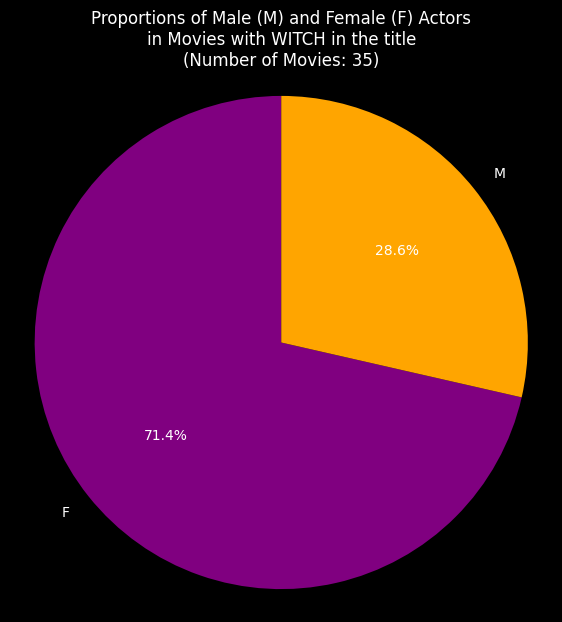

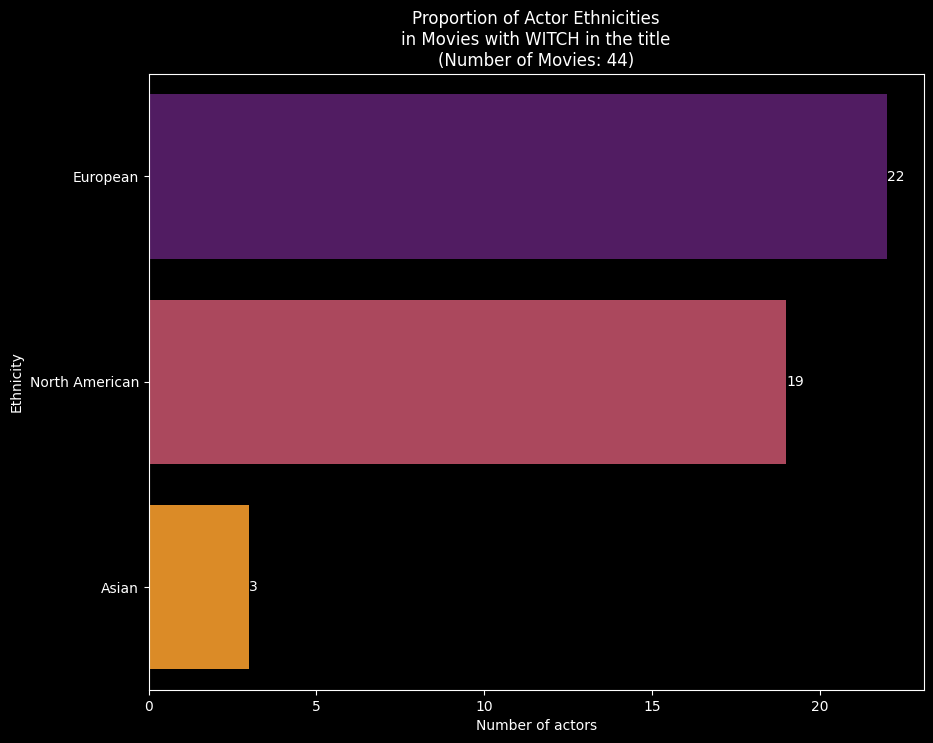

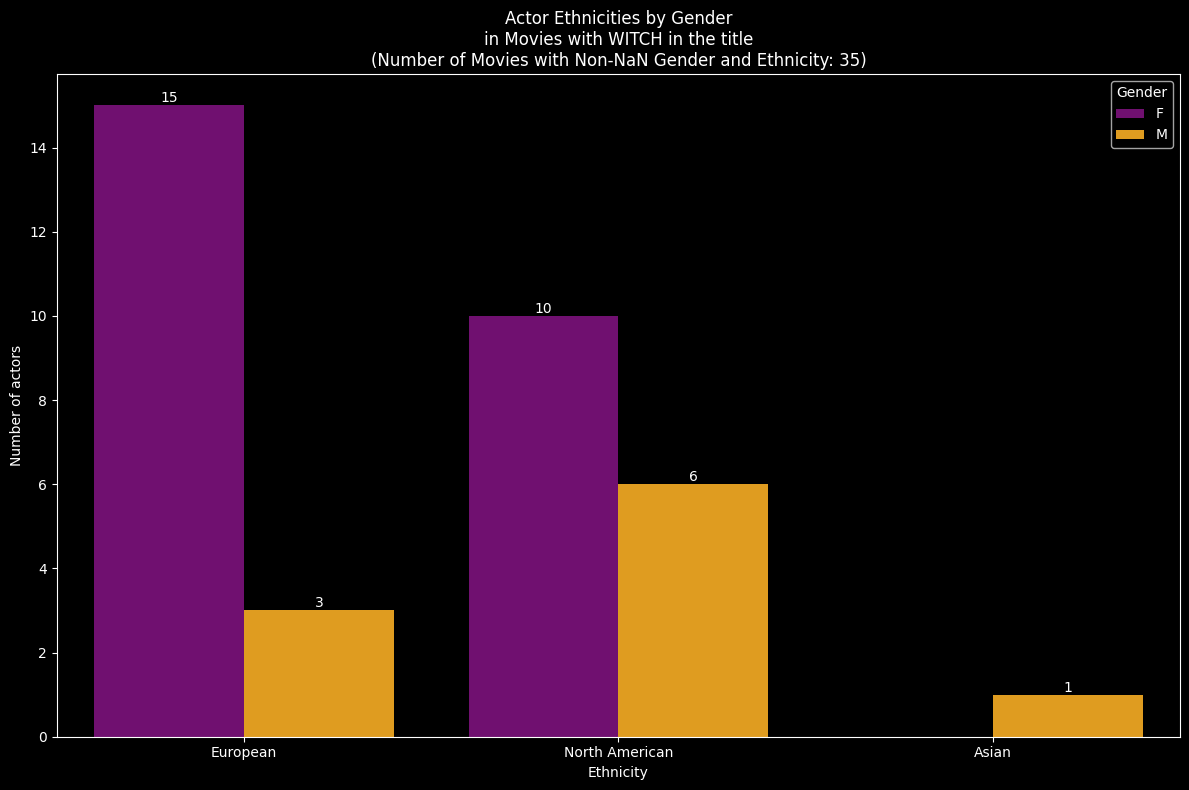

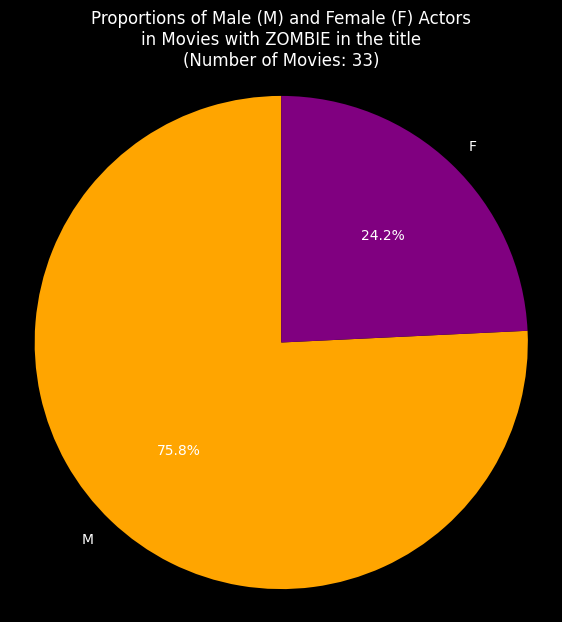

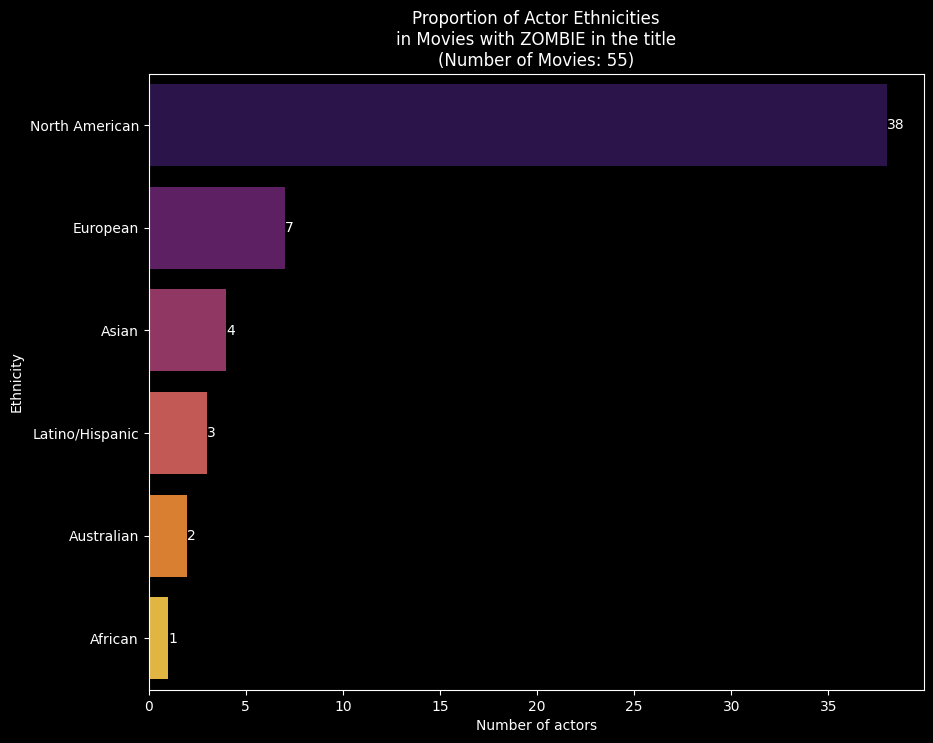

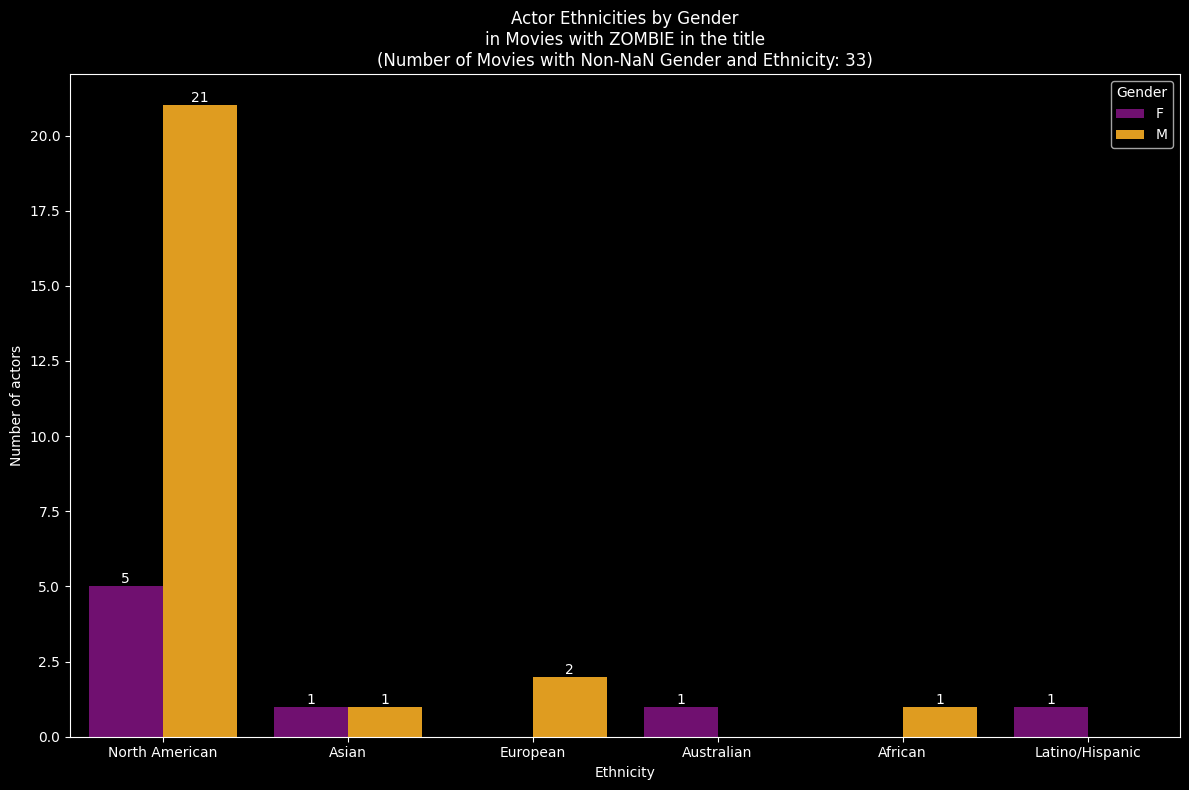

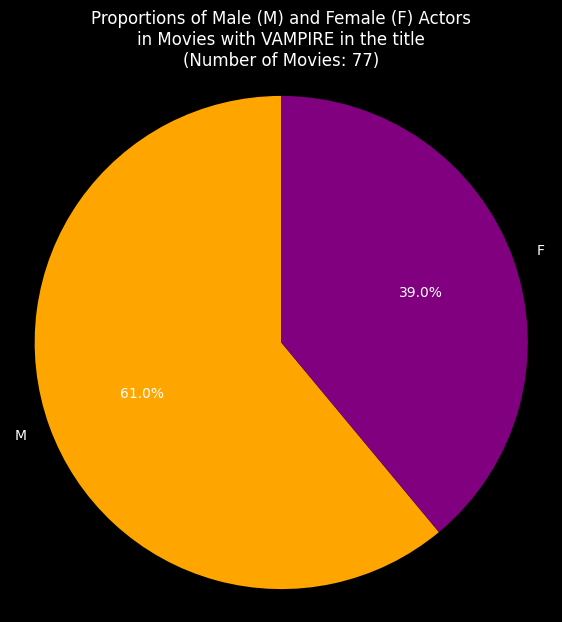

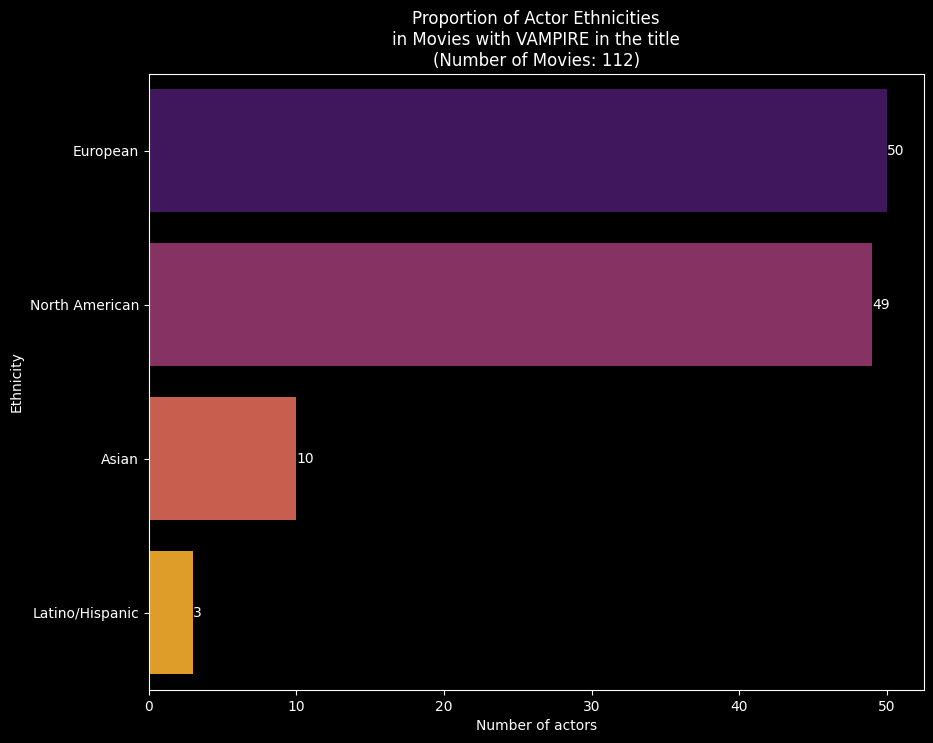

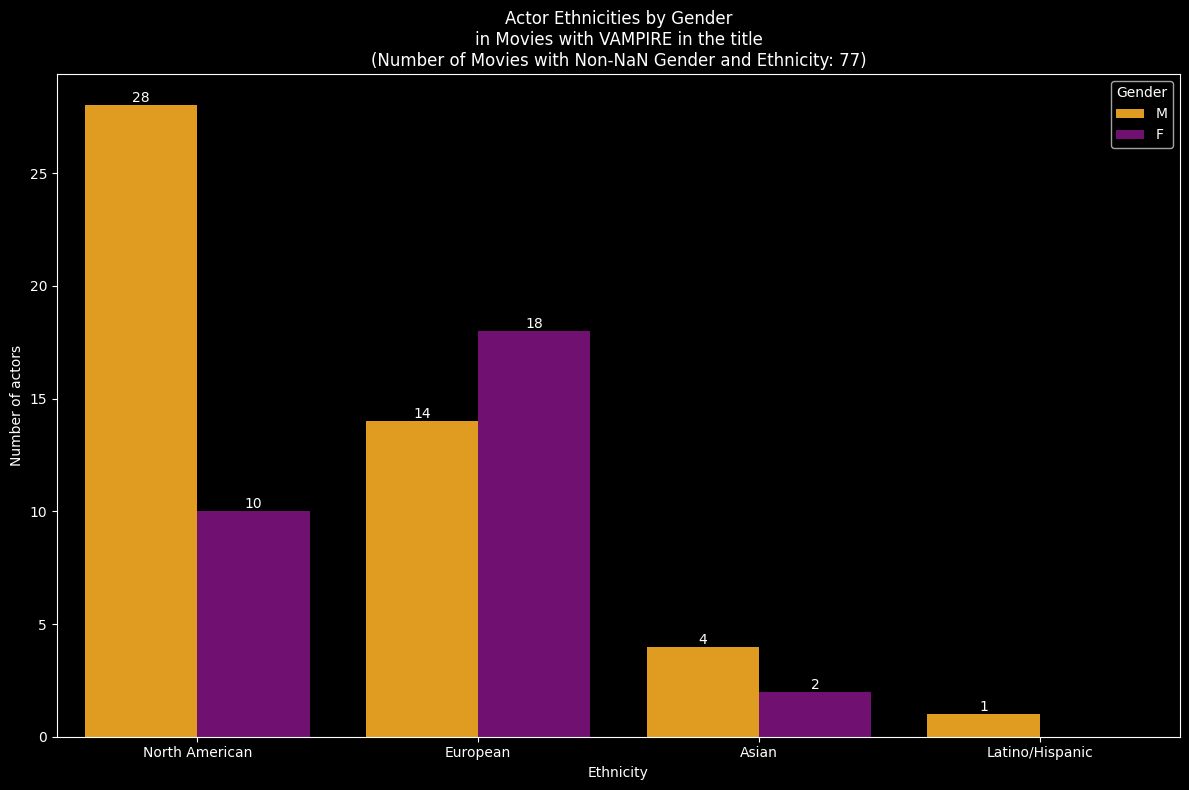

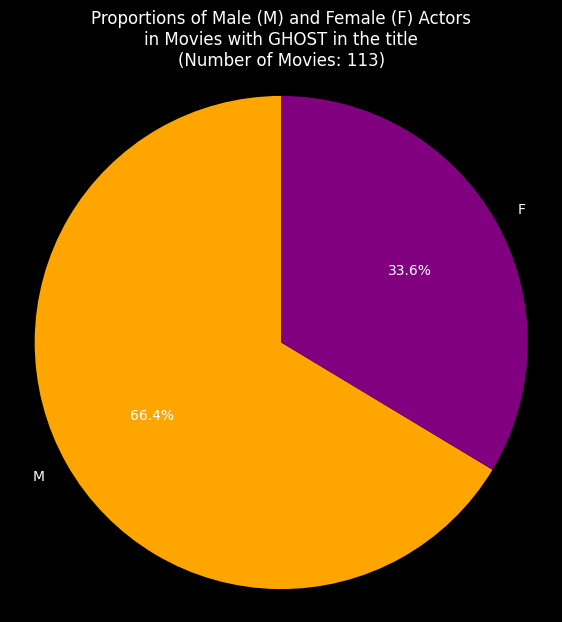

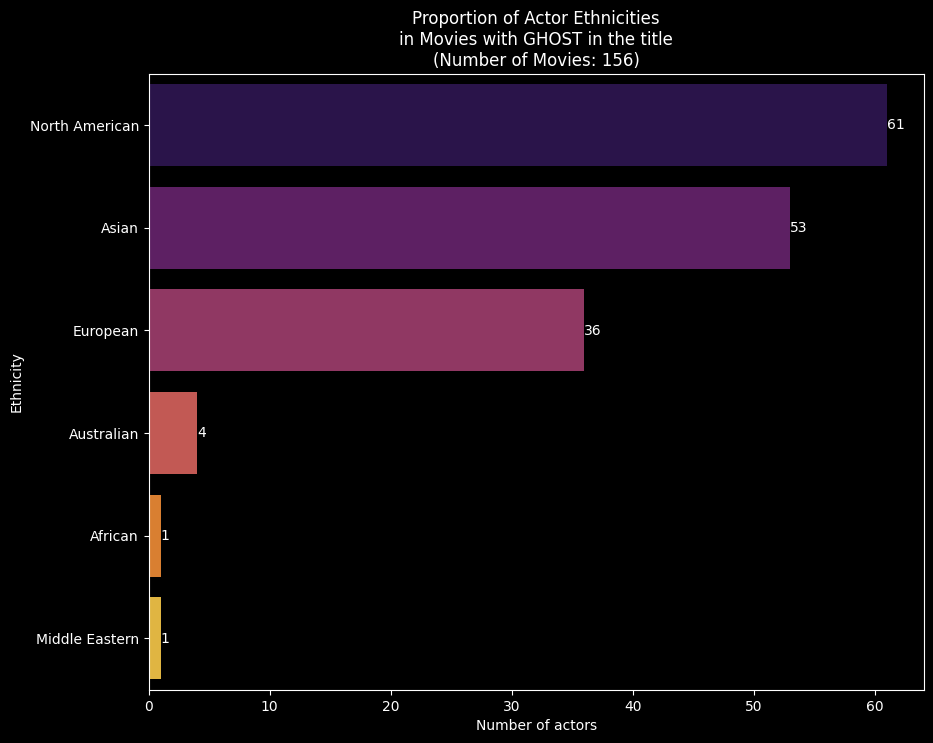

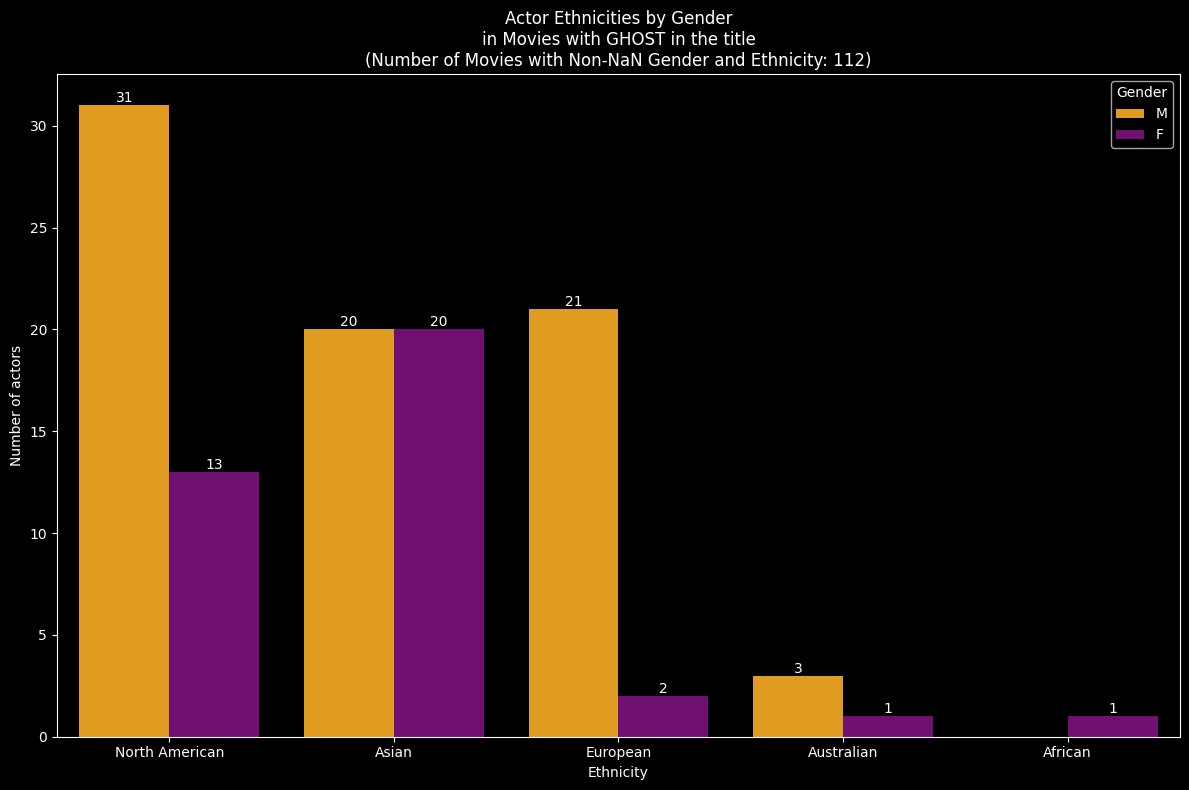

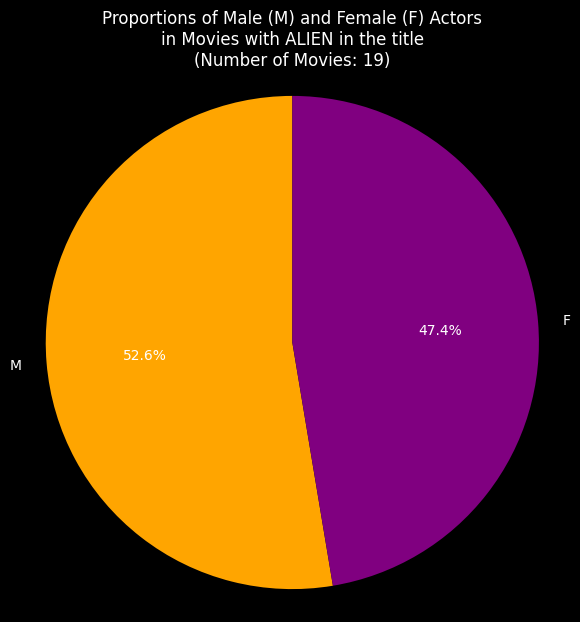

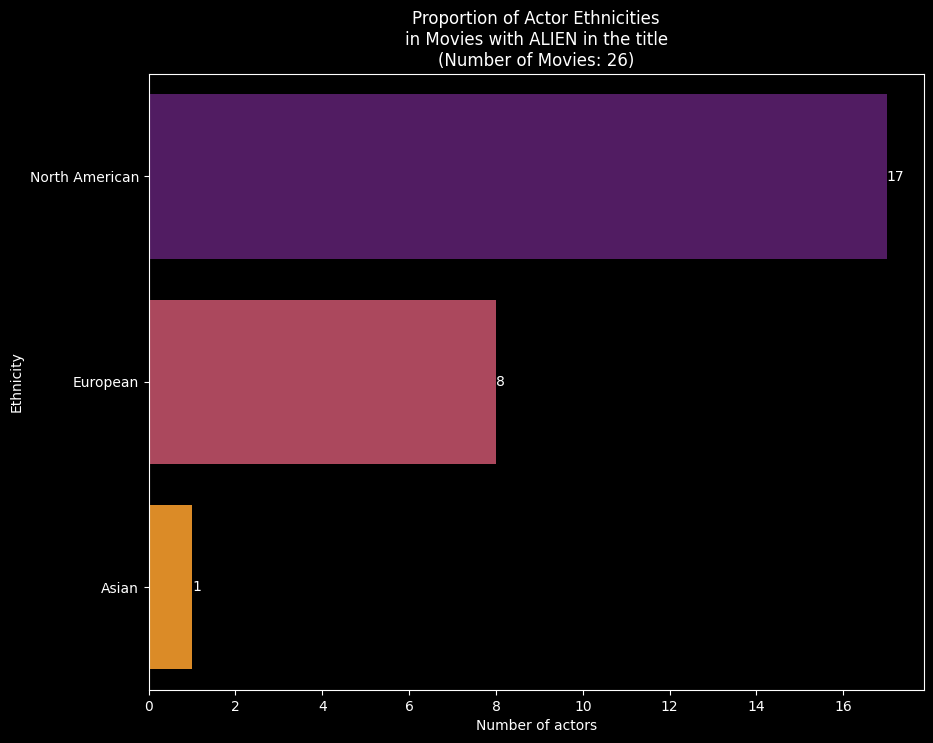

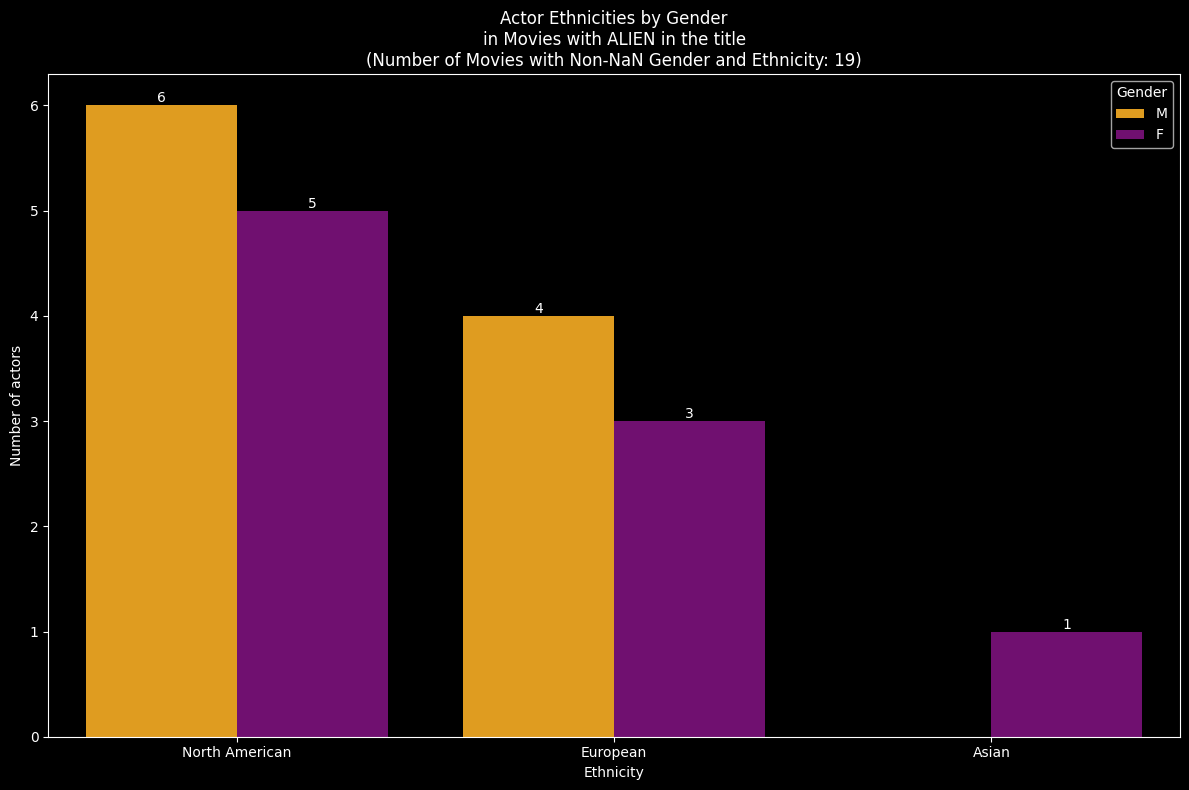

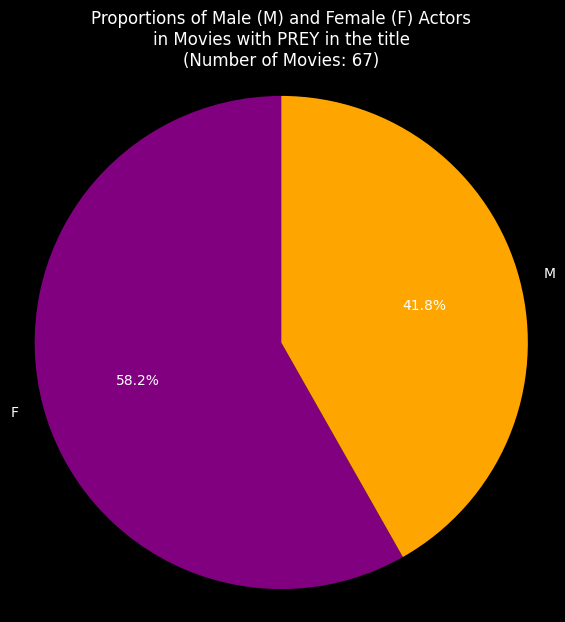

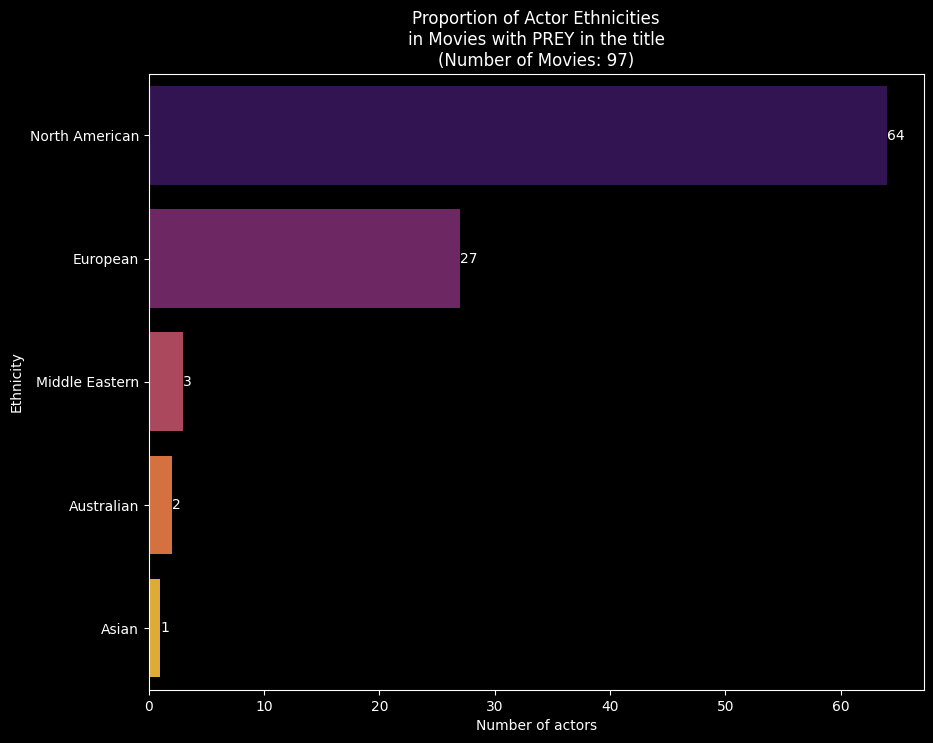

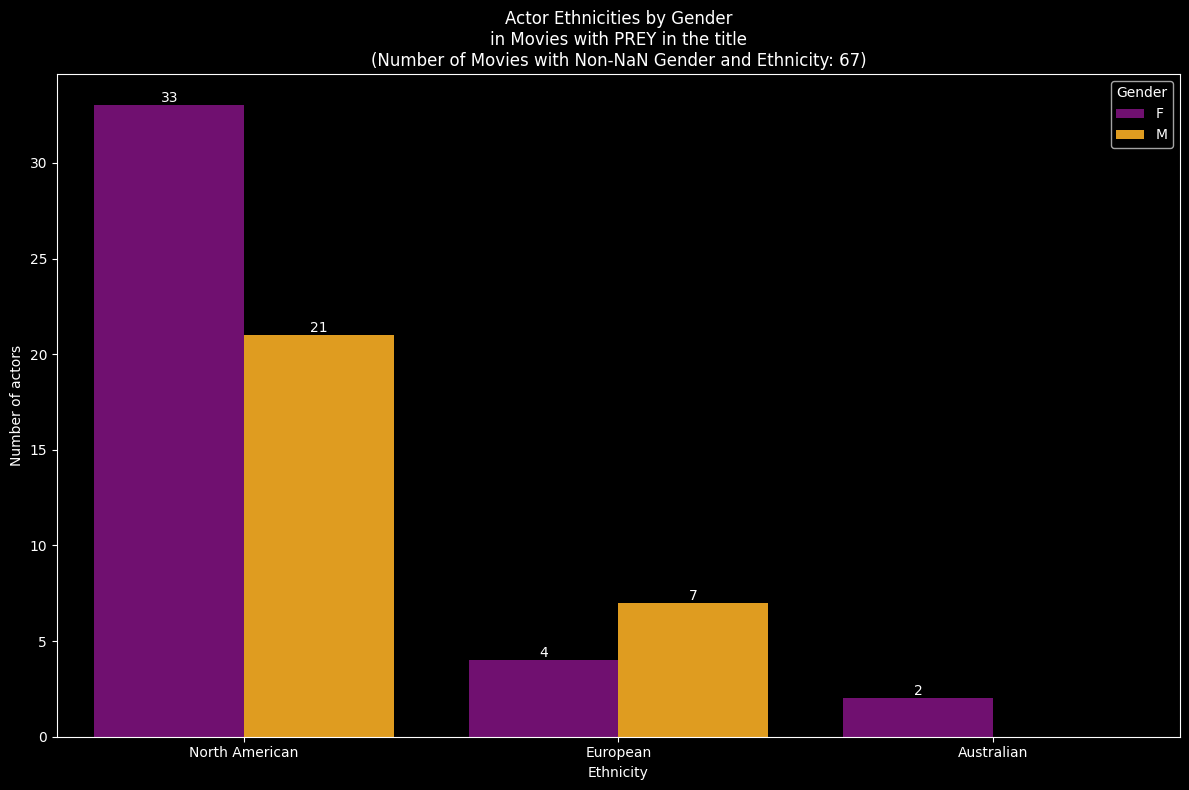

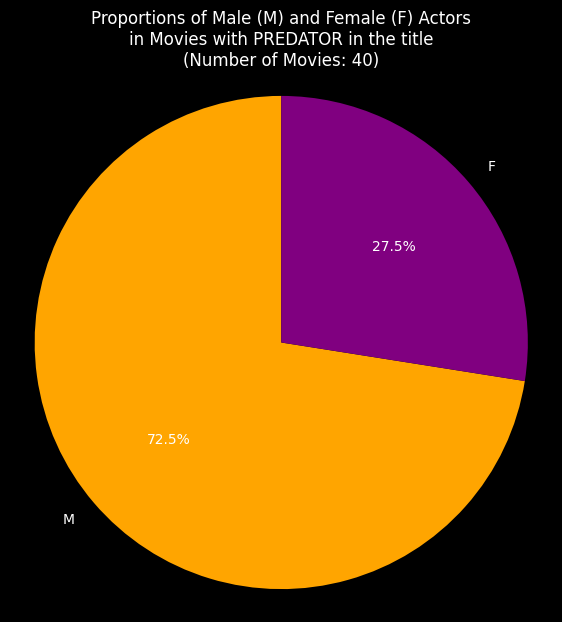

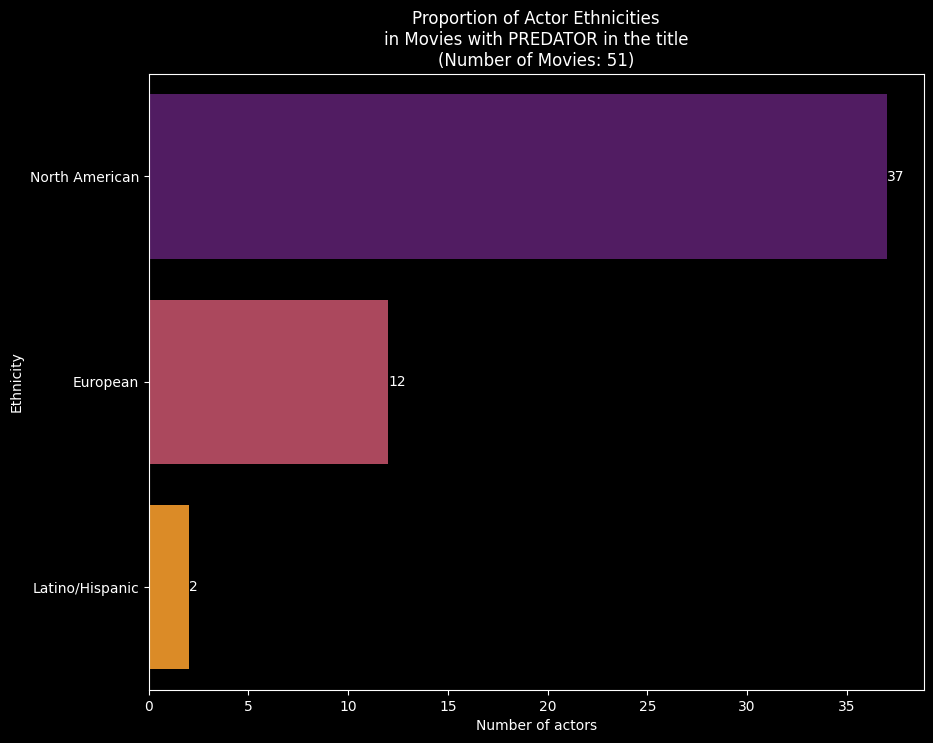

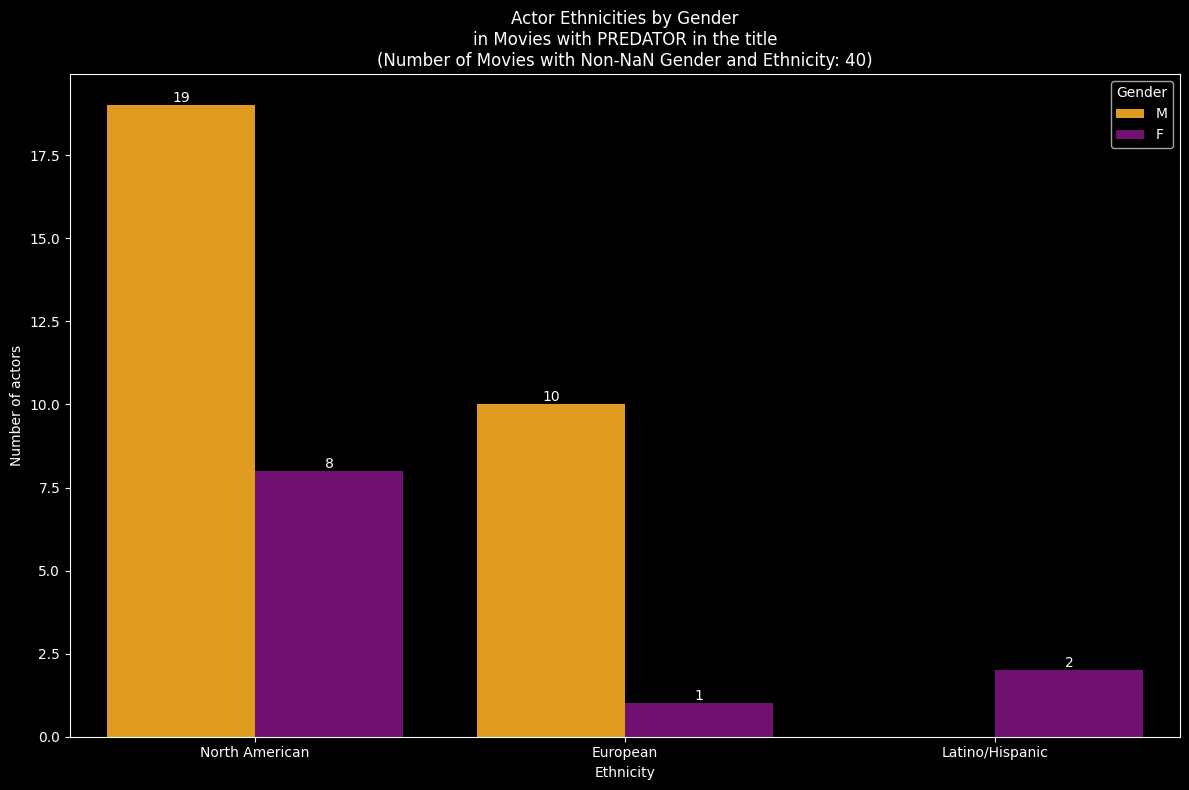

In [10]:
# retrieve the processed dfs with actor information saved in the data folder
# plot the graphs with actor profiles for each keyword in movie titles

witch_df= pd.read_csv('data/processed_data_for_titles/witch.csv')
witch_ethnicities=plot_demographics(witch_df, 'witch')

zombie_df= pd.read_csv('data/processed_data_for_titles/zombie.csv')
zombie_ethnicities=plot_demographics(zombie_df, 'zombie')

vampire_df= pd.read_csv('data/processed_data_for_titles/vampire.csv')
vampire_ethnicities=plot_demographics(vampire_df, 'vampire')

ghost_df= pd.read_csv('data/processed_data_for_titles/ghost.csv')
ghost_ethnicities=plot_demographics(ghost_df, 'ghost')

alien_df= pd.read_csv('data/processed_data_for_titles/alien.csv')
alien_ethnicities=plot_demographics(alien_df, 'alien')

prey_df= pd.read_csv('data/processed_data_for_titles/prey.csv')
prey_ethnicities=plot_demographics(prey_df, 'prey')

predator_df= pd.read_csv('data/processed_data_for_titles/predator.csv')
predator_ethnicities=plot_demographics(predator_df, 'predator')



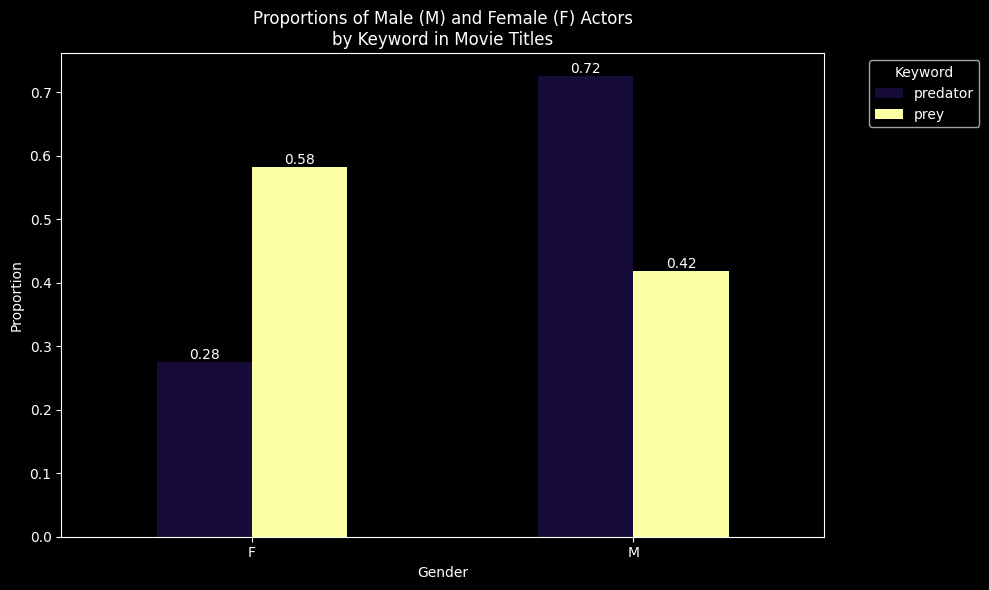

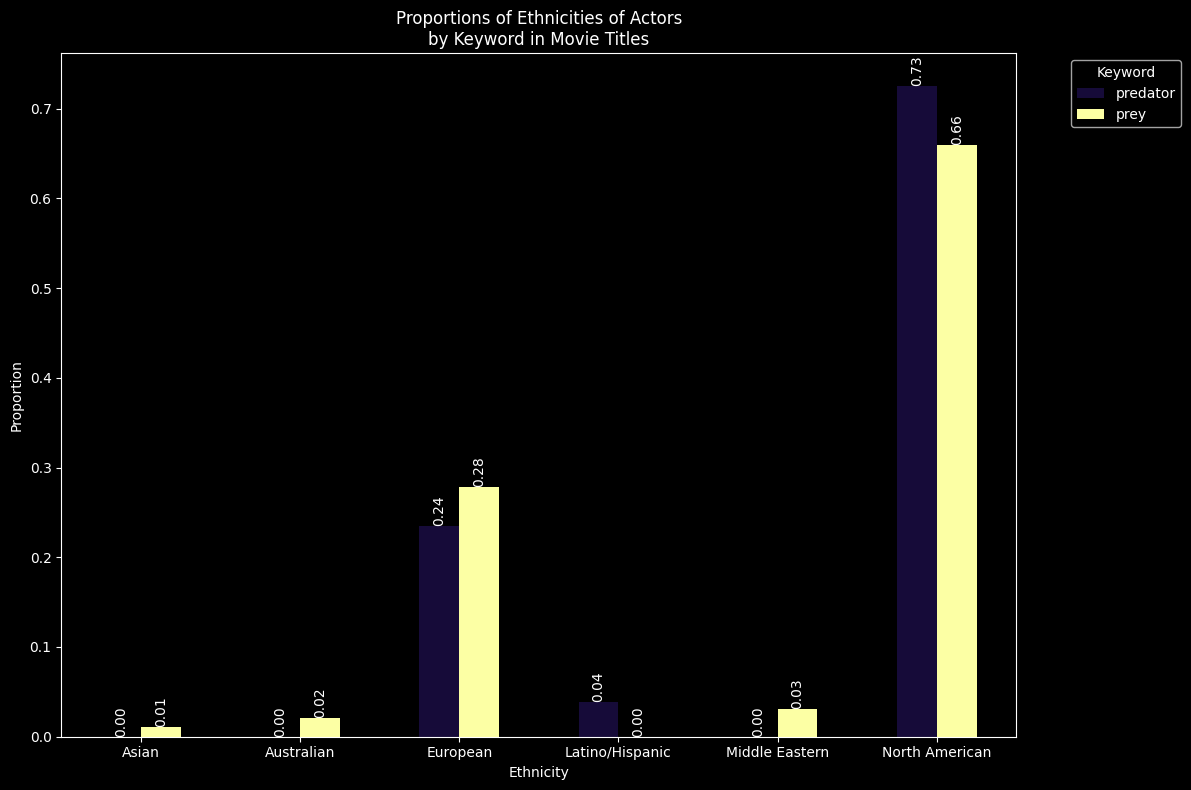

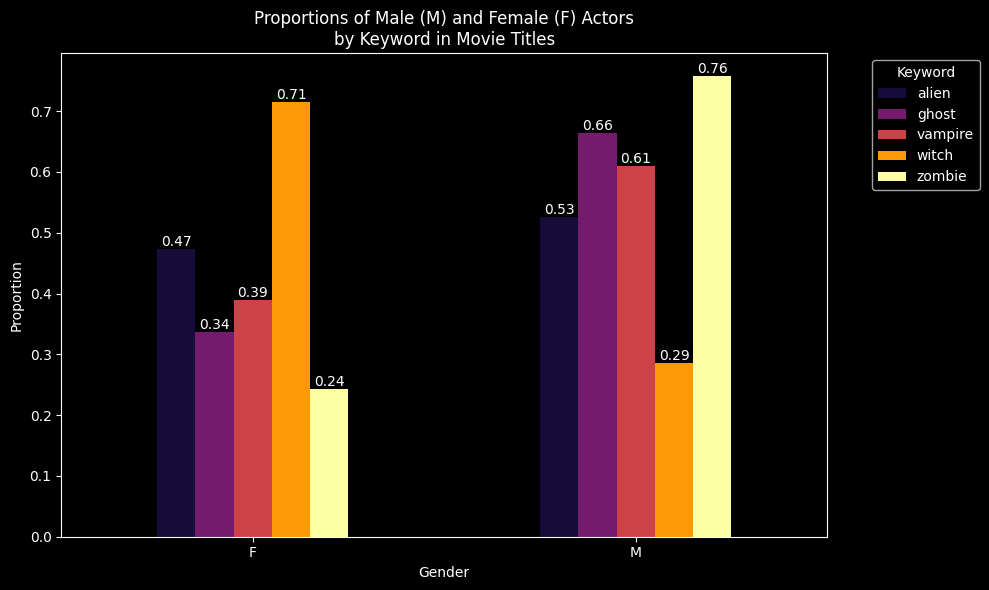

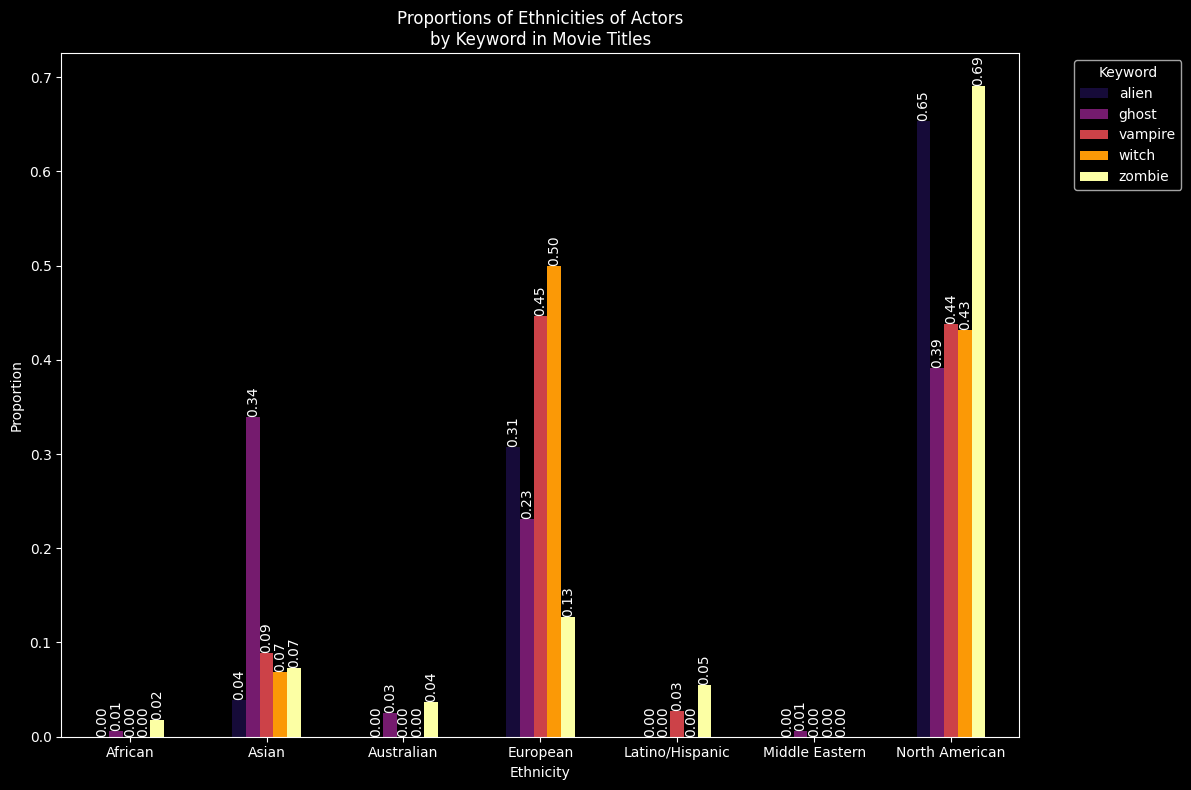

In [13]:
# compare actor profiles in movies with different 'monsters' in their titles
plot_demographics_multiple_keywords([prey_df, predator_df], ['prey', 'predator'])
# compare actor profiles in movies with 'predator' and 'prey' in their titles
plot_demographics_multiple_keywords([alien_df, zombie_df, vampire_df, witch_df, ghost_df], ['alien', 'zombie', 'vampire', 'witch', 'ghost'])